In [554]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = (_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def zero_grad(self):
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')

        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = backward
        return out
    
    def __radd__(self,other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad


        out._backward = backward
        return out
    
    def __sub__(self,other):
        return self + -other
        out._backward = backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')

        def backward():
            self.grad = out.data * out.grad
        out._backward = backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    
    def __truediv__(self,other):
        return self * other**-1

    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting in or float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        
        out._backward = backward
        return out
    
    def __sub__(self,other):
        return self + -other

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for n in reversed(topo):
            n._backward()
        

In [555]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [556]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f ; L.label='L'

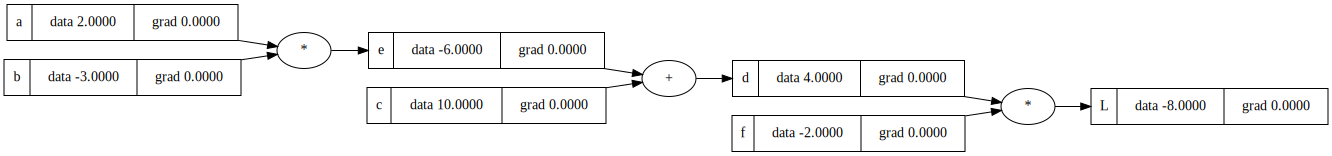

In [557]:
draw_dot(L)

In [558]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

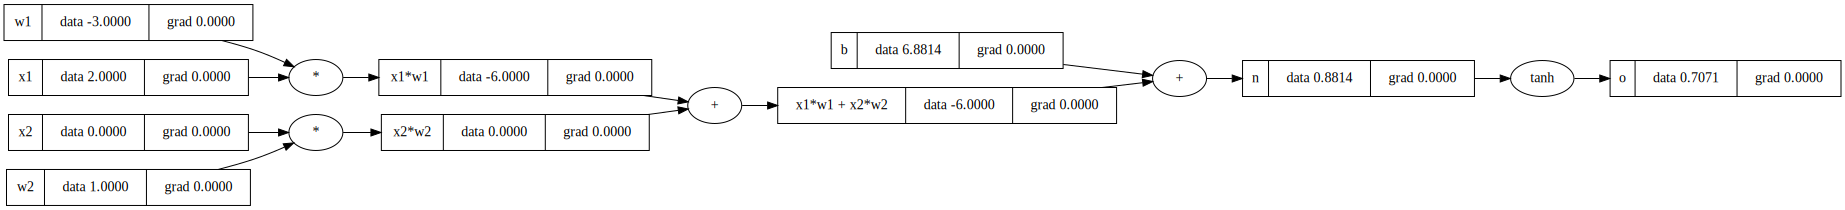

In [559]:
draw_dot(o)

In [560]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

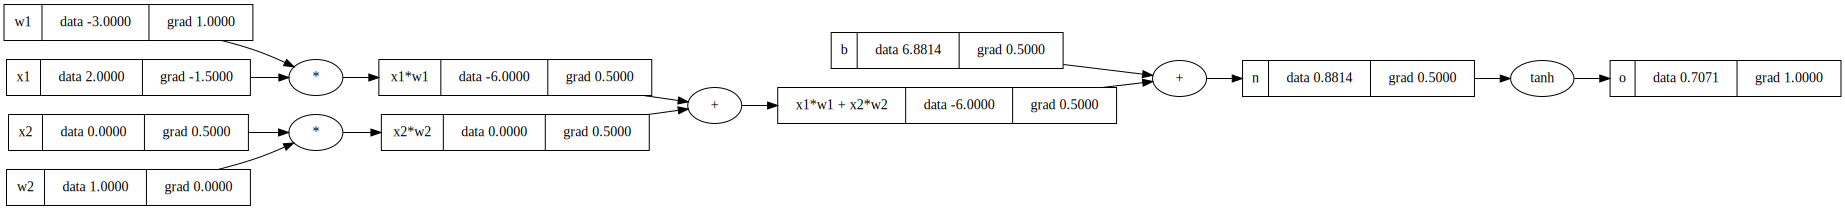

In [561]:
o.backward()

draw_dot(o)

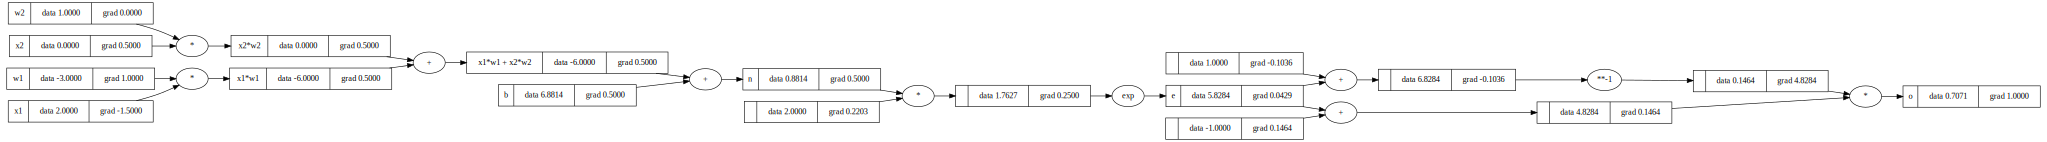

In [562]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp() ; e.label = 'e'
o = (e - 1) / (e + 1) ; o.label = 'o'
# ---
o.backward()
draw_dot(o)


# Neuron Creation

![alt text](neuron_model.jpeg)

![alt text](neural_net2.jpeg)

In [563]:
import random

class Neuron:
    # nin == number of inputs
    def __init__(self, nin):
        # Weight of inputs
        self.w = [Value(random.uniform(-1,1), label=f"weight_{i}") for i in range(nin)]
        # Bias of the neuron
        self.b = Value(random.uniform(-1,1), label='b')
    
    def __call__(self, x):
        # w * x + b
        # dot product
        linear_combination = sum((wi * xi for wi,xi in zip(self.w,x)), self.b)
        # Activation
        out = linear_combination.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    def zero_grad(self):
        for w in self.w:
            w.zero_grad()
        self.b.zero_grad()

class Layer:
    # nin == number of inputs
    # nout == number of outputs
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # params = []
        # for n in self.neuron:
        #     params.extend(n.parameters())
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def zero_grad(self):
        for n in self.neurons:
            n.zero_grad()

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for l in self.layers:
            l.zero_grad()

x = [2.0, 3.0]
n = MLP(3, [4,4,1])

result = n(x)

result.backward()

In [564]:
xs = [
    [2.0, 3.0, -1.0],
    [3,-1,0.5],
    [.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7791160578445917),
 Value(data=0.8184217821839905),
 Value(data=0.846076528565952),
 Value(data=0.8525386703962724)]

In [565]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys,ypred)))
loss

Value(data=6.78519088687393)

In [566]:
loss.backward()

In [567]:
len(n.parameters())

41

In [568]:
# Gradient descent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [569]:
for step in range(30):
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys,ypred)))
    print(loss)
    n.zero_grad()
    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad
print(ypred)

Value(data=6.652902591483975)
Value(data=6.5015144508746525)
Value(data=6.316720533525247)
Value(data=6.088985748801816)
Value(data=5.806600334005322)
Value(data=5.456615718244849)
Value(data=5.028016370227809)
Value(data=4.518568879350305)
Value(data=3.944620233625954)
Value(data=3.3467641295804387)
Value(data=2.7801056712519476)
Value(data=2.2903632429341156)
Value(data=1.8963215309590038)
Value(data=1.592013646801578)
Value(data=1.3596853612628514)
Value(data=1.180546141252361)
Value(data=1.039459891036351)
Value(data=0.9256036800587917)
Value(data=0.831611056856513)
Value(data=0.7525188600267662)
Value(data=0.6849396604885633)
Value(data=0.6265010076050513)
Value(data=0.5754880319015824)
Value(data=0.5306205744727468)
Value(data=0.4909141902722593)
Value(data=0.4555922455119903)
Value(data=0.42402902894692346)
Value(data=0.39571185425740363)
Value(data=0.3702149954986283)
Value(data=0.3471811720562897)
[Value(data=0.7690987410988975), Value(data=-0.8164032113273795), Value(data=-0.

# micrograd demo with our version of micrograd

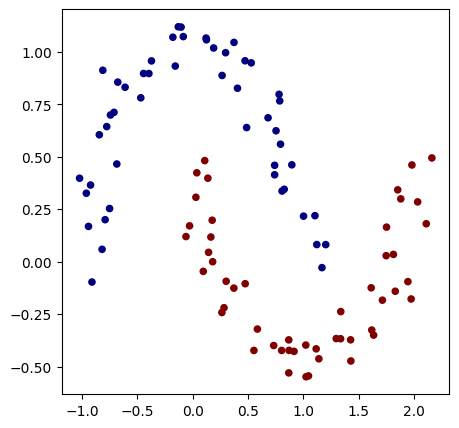

In [570]:
import sklearn

np.random.seed(1337)
random.seed(1337)
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [571]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


number of parameters 337


In [572]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7840043023159258) 0.68


In [573]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.7840043023159258, accuracy 68.0%
step 1 loss 0.5346887893624205, accuracy 73.0%
step 2 loss 0.40486112398826374, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.2942618979033041, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.25577580370370173, accuracy 90.0%
step 7 loss 0.24353269446140008, accuracy 91.0%
step 8 loss 0.2331166633588174, accuracy 91.0%
step 9 loss 0.22371429713875027, accuracy 91.0%
step 10 loss 0.21478840620418216, accuracy 91.0%
step 11 loss 0.20603142190103874, accuracy 91.0%
step 12 loss 0.19722264277587243, accuracy 92.0%
step 13 loss 0.18824544635214926, accuracy 93.0%
step 14 loss 0.17902966856680746, accuracy 94.0%
step 15 loss 0.16967500545392222, accuracy 94.0%
step 16 loss 0.16033439848659783, accuracy 94.0%
step 17 loss 0.1520098627872637, accuracy 96.0%
step 18 loss 0.14550876426551498, accuracy 96.0%
step 19 loss 0.15276142639895657, accuracy 95.0%
step 20 loss 0.14406510423987695, acc

(-1.548639298268643, 1.951360701731357)

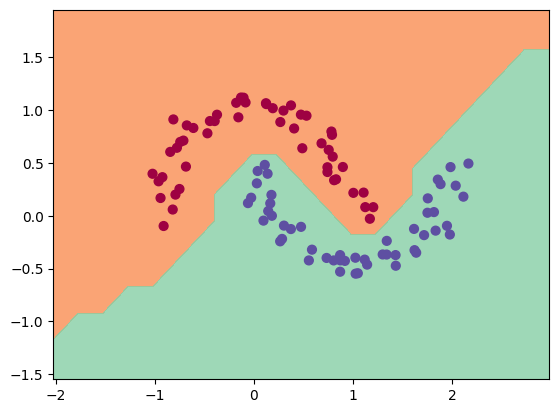

In [574]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
